In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sn

from collections import defaultdict

plt.style.use('seaborn-ticks')

In [16]:
col_names = ['COLLECTION_TIME', 'SOURCE_TIME', 'SEQ_NUM', 'TICK_TYPE', 'MARKET_CENTER', 'PRICE', 'SIZE']

def comp_corr(input_folder, output_folder, dates, etf_ticker, comp_ticker):
    """

    # Calculate correlation between components and eft price

    Args:
        input_folder (str): tick data folder
        output_folder ([type]): output folder
        dates (list of str): yyyymmdd
        etf_ticker (str): ticker for etf of interest
        comp_ticker (list of ticker): component tickers
    Returns:
        csv file with each row represent correlation of corresponding ticker with eft
        and each column represent the date.

    """

    correlations = {}
    for date in dates:

        date_corr = {}

        etf = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(etf_ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])

        for ticker in tickers:
            comp = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                                        names=col_names, parse_dates=[0, 1])

            combine = pd.merge(left=etf, right=comp, left_on='COLLECTION_TIME', right_on='COLLECTION_TIME', how='outer')
            combine = combine.sort_values('COLLECTION_TIME')

            combine = combine.fillna(method='pad', axis=0)
            corr = combine[['PRICE_x', 'PRICE_y']].corr()
            date_corr[ticker] = corr.iloc[1,0]
        correlations[date] = date_corr

        print('finished {}'.format(date))

    return pd.DataFrame(correlations)

## Calc Correlations

In [15]:
tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'IBM', 'MSFT', 'V', 'JPM', 
           'INTC', 'XOM', 'WMT', 'WBA', 'VZ', 'UNH', 'TRV', 'PFE', 'NKE', 'MRK', 
           'MMM', 'MCD', 'JNJ', 'HD', 'DOW']

In [13]:
input_folder = r'G:\FIN566\ticks_201910'
output_folder = r'G:\FIN566\ticks_201910'
dates = [
    '20191001', '20191002', '20191003', '20191004',
    '20191007', '20191008', '20191009', '20191010',
    '20191011', '20191014', '20191015', '20191016',
    '20191017', '20191018', '20191021', '20191022',
    '20191023', '20191024', '20191025', '20191028',
    '20191029', '20191030', '20191031', '20191101'   
    ]
# correlations = comp_corr(input_folder, output_folder, dates, 'SPY', tickers)

## Analysis of Correlation

### Heatmap

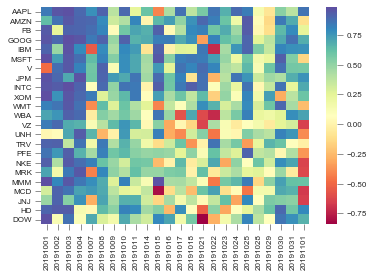

In [33]:
sn.heatmap(correlations, cbar=True, cmap="Spectral")

### Mean & Variance

In [34]:
correlations = correlations.T

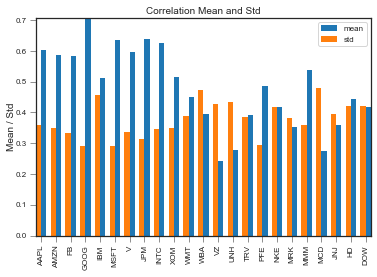

In [63]:
mean = correlations.mean()
std = correlations.std()

fig, ax = plt.subplots()

x = np.arange(len(mean))

width = 0.35

ax.bar(x+width/2, mean, width, label='mean')
ax.bar(x-width/2, std, width, label='std')

ax.set_ylabel('Mean / Std')
ax.set_title('Correlation Mean and Std')
ax.set_xticks(x)
ax.set_xticklabels(mean.index)
ax.legend()

ax.tick_params(axis='x', labelrotation=90)

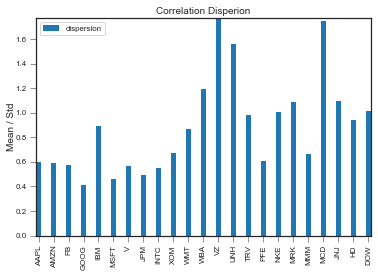

In [68]:
fig, ax = plt.subplots()
ax.bar(x, std/mean, width, label='mean')

ax.set_ylabel('Mean / Std')
ax.set_title('Correlation Disperion')
ax.set_xticks(x)
ax.set_xticklabels(mean.index)
ax.legend(['dispersion'])

ax.tick_params(axis='x', labelrotation=90)

GOOG stands out in terms of magnitude and persistence of correlation with SPY

Second layer may include MSFT, JPM, INTC, V, 

## Analysis on Driven Factors

### Trade Volume 

In [3]:
volume = defaultdict(int)
for ticker in tickers:
    for date in dates:
        comp = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                        names=col_names, parse_dates=[0, 1])
        volume[ticker] += comp.shape[0]
for ticker in tickers:
    volume[ticker] /= len(dates) 

NameError: name 'tickers' is not defined

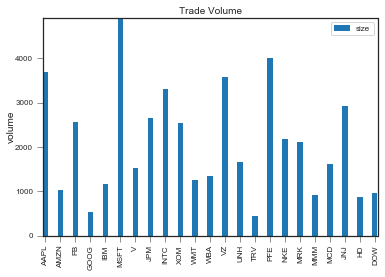

In [90]:
fig, ax = plt.subplots()

x = np.arange(len(volume))

ax.bar(x, volume.values(), width, label='mean')

ax.set_ylabel('volume')
ax.set_title('Trade Volume')
ax.set_xticks(x)
ax.set_xticklabels(mean.index)
ax.legend(['size'])

ax.tick_params(axis='x', labelrotation=90)

Most tickers are in the acceptable range

The most liquid tickers are MSFT, AAPL, INTC, FB, FFE, VZ, JNJ

### Price change prediction 

#### Calculate Future Return and Historical Return

In [7]:
date = '20191001'
ticker = 'MSFT'
etf_ticker = 'SPY'
input_folder = r'G:\FIN566\ticks_201910'
output_folder = r'G:\FIN566\ticks_201910'

window = pd.Timedelta('0 days 00:00:10.000000')

In [8]:
etf = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(etf_ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])
comp = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])

In [9]:
combine = pd.merge(left=etf, right=comp, left_on='COLLECTION_TIME', right_on='COLLECTION_TIME', 
                   how='outer', suffixes=['_'+etf_ticker, '_'+ticker])
combine = combine.sort_values('COLLECTION_TIME')
combine = combine.fillna(method='pad', axis=0)

In [10]:
## calculate future return

combine_values = combine.values

comp_return = np.zeros((combine_values.shape[0], 1))
etf_return = np.zeros((combine_values.shape[0], 1))

n = combine_values.shape[0]

for i in range(n):
    j = i + 1
    while j < n and combine_values[j,0] - combine_values[i,0] < window:
        j += 1
    
    if j >= n:
        etf_return[i, 0] = np.nan
        comp_return[i, 0]= np.nan
    else:
        etf_return[i, 0] = combine_values[j, 5]/combine_values[i, 5] - 1
        comp_return[i, 0] = combine_values[j, 11]/combine_values[i, 11] - 1

combine['RETURN_'+etf_ticker] = etf_return
combine['RETURN_'+ticker] = comp_return

In [11]:
## calculate features
windows = {'1': pd.Timedelta('0 days 00:00:10.000000'),
           '5': pd.Timedelta('0 days 00:00:30.000000'),
           '10': pd.Timedelta('0 days 00:01:00.000000'),
           '30': pd.Timedelta('0 days 00:01:30.000000')}

combine_values = combine.values

n = combine_values.shape[0]
for k, window in windows.items():
    
    comp_return = np.zeros((combine_values.shape[0], 1))
    etf_return = np.zeros((combine_values.shape[0], 1))
    
    for i in range(n):
        j = i - 1
        
        while j >=0 and combine_values[i,0] - combine_values[j,0] < window:
            j -= 1

        if j < 0:
            etf_return[i, 0] = np.nan
            comp_return[i, 0]= np.nan
        else:
            etf_return[i, 0] = combine_values[i, 5]/combine_values[j, 5] - 1
            comp_return[i, 0] = combine_values[i, 11]/combine_values[j, 11] - 1

    combine['RETURN_'+etf_ticker+'_'+k] = etf_return
    combine['RETURN_'+ticker+'_'+k] = comp_return

#### Run Regression

#### SPY as dependent variable

In [25]:
combine_valid = combine.dropna(how='any', axis=0)

x_cols_msft = []
x_cols_spy = []
for k, _ in windows.items():
    x_cols_msft.append('RETURN_SPY_'+k)
    x_cols_spy.append('RETURN_MSFT_'+k)
x_cols = x_cols_msft+x_cols_spy
      
y = combine_valid.RETURN_SPY.to_list()
x = combine_valid[x_cols]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     36.33
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.59e-57
Time:                        15:05:19   Log-Likelihood:             1.0302e+05
No. Observations:               14641   AIC:                        -2.060e+05
Df Residuals:                   14632   BIC:                        -2.059e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.622e-05    1.8e-06     -9.

#### MSFT as dependent variable

In [26]:
combine_valid = combine.dropna(how='any', axis=0)

y = combine_valid.RETURN_MSFT.to_list()
x = combine_valid[x_cols]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     174.3
Date:                Sat, 12 Dec 2020   Prob (F-statistic):          2.28e-282
Time:                        15:05:30   Log-Likelihood:                 98461.
No. Observations:               14641   AIC:                        -1.969e+05
Df Residuals:                   14632   BIC:                        -1.968e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.519e-05   2.45e-06     -6.

Comparing results from the two regressions, we find that the historical return is a strong predictor for MSFT. In the opposite direction, although MSFT show certain predictability for SPY, but much weeker.

#### Cofficients Evolutions (MSFT as dependent variable)

In [40]:
ticker = 'MSFT'
etf_ticker = 'SPY'
input_folder = r'G:\FIN566\ticks_201910'
output_folder = r'G:\FIN566\ticks_201910'

window = pd.Timedelta('0 days 00:00:10.000000')
windows = {'1': pd.Timedelta('0 days 00:00:01.000000'),
           '5': pd.Timedelta('0 days 00:00:05.000000'),
           '10': pd.Timedelta('0 days 00:00:10.000000'),
           '30': pd.Timedelta('0 days 00:00:30.000000'),
           '60': pd.Timedelta('0 days 00:01:00.000000'),
           '90': pd.Timedelta('0 days 00:01:30.000000')
          }

params = pd.DataFrame()
pvalues = pd.DataFrame()

for date in dates:
    
    print('working on {}'.format(date))
    
    etf = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(etf_ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])
    comp = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])
    combine = pd.merge(left=etf, right=comp, left_on='COLLECTION_TIME', right_on='COLLECTION_TIME', 
                   how='outer', suffixes=['_'+etf_ticker, '_'+ticker])
    combine = combine.sort_values('COLLECTION_TIME')
    combine = combine.fillna(method='pad', axis=0)
    
    ## calculate future return
    combine_values = combine.values

    comp_return = np.zeros((combine_values.shape[0], 1))
    etf_return = np.zeros((combine_values.shape[0], 1))

    n = combine_values.shape[0]

    for i in range(n):
        j = i + 1
        while j < n and combine_values[j,0] - combine_values[i,0] < window:
            j += 1

        if j >= n:
            etf_return[i, 0] = np.nan
            comp_return[i, 0]= np.nan
        else:
            etf_return[i, 0] = combine_values[j, 5]/combine_values[i, 5] - 1
            comp_return[i, 0] = combine_values[j, 11]/combine_values[i, 11] - 1

    combine['RETURN_'+etf_ticker] = etf_return
    combine['RETURN_'+ticker] = comp_return
    
    ## calculate features

    combine_values = combine.values

    n = combine_values.shape[0]
    for k, window in windows.items():

        comp_return = np.zeros((combine_values.shape[0], 1))
        etf_return = np.zeros((combine_values.shape[0], 1))

        for i in range(n):
            j = i - 1

            while j >=0 and combine_values[i,0] - combine_values[j,0] < window:
                j -= 1

            if j < 0:
                etf_return[i, 0] = np.nan
                comp_return[i, 0]= np.nan
            else:
                etf_return[i, 0] = combine_values[i, 5]/combine_values[j, 5] - 1
                comp_return[i, 0] = combine_values[i, 11]/combine_values[j, 11] - 1

        combine['RETURN_'+etf_ticker+'_'+k] = etf_return
        combine['RETURN_'+ticker+'_'+k] = comp_return

    # run regression
    combine_valid = combine.dropna(how='any', axis=0)
    x_cols_msft = []
    x_cols_spy = []
    for k, _ in windows.items():
        x_cols_msft.append('RETURN_SPY_'+k)
        x_cols_spy.append('RETURN_MSFT_'+k)
    x_cols = x_cols_msft+x_cols_spy
    
    y = combine_valid.RETURN_MSFT.to_list()
    x = combine_valid[x_cols]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    
    # collect parameters
    params[date] = model.params
    pvalues[date] = model.pvalues

working on 20191001
working on 20191002
working on 20191003
working on 20191004
working on 20191007
working on 20191008
working on 20191009
working on 20191010
working on 20191011
working on 20191014
working on 20191015
working on 20191016
working on 20191017
working on 20191018
working on 20191021
working on 20191022
working on 20191023
working on 20191024
working on 20191025
working on 20191028
working on 20191029
working on 20191030
working on 20191031
working on 20191101


In [42]:
params = params.T
pvalues = pvalues.T

In [67]:
col = 'RETURN_SPY_30'
pd.concat([params[col], pvalues[col]], axis=1)

,RETURN_SPY_30,RETURN_SPY_30
20191001,0.133580,1.619940e-19
20191002,0.177596,3.458475e-06
20191003,-0.146935,3.385577e-04
20191004,0.273987,1.611675e-07
20191007,-0.606138,1.723100e-06
20191008,-0.023652,5.229398e-01
20191009,0.511613,3.334502e-09
20191010,0.633523,1.570682e-59
20191011,0.146856,3.788682e-06
20191014,0.091998,3.970097e-02


#### Intraseconds Analysis

In [18]:
ticker = 'MSFT'
etf_ticker = 'SPY'
input_folder = r'G:\FIN566\ticks_201910'
output_folder = r'G:\FIN566\ticks_201910'

window = pd.Timedelta('0 days 00:00:01.000000')
windows = {'1': pd.Timedelta('0 days 00:00:01.000000'),
           '2': pd.Timedelta('0 days 00:00:02.000000'),
           '3': pd.Timedelta('0 days 00:00:03.000000'),
           '10': pd.Timedelta('0 days 00:00:10.000000'),
           '15': pd.Timedelta('0 days 00:00:15.000000'),
           '30': pd.Timedelta('0 days 00:00:30.000000')
          }

params = pd.DataFrame()
pvalues = pd.DataFrame()

for date in dates:
    
    print('working on {}'.format(date))
    
    etf = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(etf_ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])
    comp = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                                    names=col_names, parse_dates=[0, 1])
    combine = pd.merge(left=etf, right=comp, left_on='COLLECTION_TIME', right_on='COLLECTION_TIME', 
                   how='outer', suffixes=['_'+etf_ticker, '_'+ticker])
    combine = combine.sort_values('COLLECTION_TIME')
    combine = combine.fillna(method='pad', axis=0)
    
    ## calculate future return
    combine_values = combine.values

    comp_return = np.zeros((combine_values.shape[0], 1))
    etf_return = np.zeros((combine_values.shape[0], 1))

    n = combine_values.shape[0]

    for i in range(n):
        j = i + 1
        while j < n and combine_values[j,0] - combine_values[i,0] < window:
            j += 1

        if j >= n:
            etf_return[i, 0] = np.nan
            comp_return[i, 0]= np.nan
        else:
            etf_return[i, 0] = combine_values[j, 5]/combine_values[i, 5] - 1
            comp_return[i, 0] = combine_values[j, 11]/combine_values[i, 11] - 1

    combine['RETURN_'+etf_ticker] = etf_return
    combine['RETURN_'+ticker] = comp_return
    
    ## calculate features

    combine_values = combine.values

    n = combine_values.shape[0]
    for k, window in windows.items():

        comp_return = np.zeros((combine_values.shape[0], 1))
        etf_return = np.zeros((combine_values.shape[0], 1))

        for i in range(n):
            j = i - 1

            while j >=0 and combine_values[i,0] - combine_values[j,0] < window:
                j -= 1

            if j < 0:
                etf_return[i, 0] = np.nan
                comp_return[i, 0]= np.nan
            else:
                etf_return[i, 0] = combine_values[i, 5]/combine_values[j, 5] - 1
                comp_return[i, 0] = combine_values[i, 11]/combine_values[j, 11] - 1

        combine['RETURN_'+etf_ticker+'_'+k] = etf_return
        combine['RETURN_'+ticker+'_'+k] = comp_return

    # run regression
    combine_valid = combine.dropna(how='any', axis=0)
    x_cols_msft = []
    x_cols_spy = []
    for k, _ in windows.items():
        x_cols_msft.append('RETURN_SPY_'+k)
        x_cols_spy.append('RETURN_MSFT_'+k)
    x_cols = x_cols_msft+x_cols_spy
    
    y = combine_valid.RETURN_MSFT.to_list()
    x = combine_valid[x_cols]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    
    # collect parameters
    params[date] = model.params
    pvalues[date] = model.pvalues
    
params = params.T
pvalues = pvalues.T

working on 20191001
working on 20191002
working on 20191003
working on 20191004
working on 20191007
working on 20191008
working on 20191009
working on 20191010
working on 20191011
working on 20191014
working on 20191015
working on 20191016
working on 20191017
working on 20191018
working on 20191021
working on 20191022
working on 20191023
working on 20191024
working on 20191025
working on 20191028
working on 20191029
working on 20191030
working on 20191031
working on 20191101


#### SPY Return

In [8]:
spy_ret = pd.read_csv(r'./SPY_Oct2019.csv')
spy_ret['return'] = (spy_ret['Adj Close'] - spy_ret['Adj Close'].shift(periods=1, axis=0))/spy_ret['Adj Close'].shift(periods=1, axis=0)

In [24]:
spy_ret = (spy_ret['return'] * 100).to_list() + [np.nan]
params['return'] = spy_ret

In [29]:
params[['RETURN_SPY_1', 'RETURN_SPY_2', 'RETURN_SPY_3',
       'RETURN_SPY_10', 'RETURN_SPY_15', 'return']]

,RETURN_SPY_1,RETURN_SPY_2,RETURN_SPY_3,RETURN_SPY_10,RETURN_SPY_15,return
20191001,0.191124,0.236922,-0.070612,0.109408,0.036139,NaN
20191002,0.170445,0.238712,0.089642,-0.018061,0.057331,-1.766460
20191003,0.399852,-0.112207,0.269092,0.093403,0.223228,0.819269
20191004,0.342558,0.122645,-0.227916,0.096585,0.230722,1.353211
20191007,-0.037579,0.440247,-0.130692,0.123148,0.274505,-0.431471
20191008,0.920076,0.228832,0.502759,0.202753,-0.060853,-1.552468
20191009,0.446969,0.180843,0.091584,-0.300520,-0.032444,0.949641
20191010,0.155929,-0.085382,0.301894,-0.200943,0.037133,0.676345
20191011,0.197383,0.198305,0.147035,0.042122,0.182615,1.036684
20191014,0.291910,0.074488,0.081146,-0.124679,0.025772,-0.111368


In [30]:
params[['RETURN_SPY_1', 'RETURN_SPY_2', 'RETURN_SPY_3',
       'RETURN_SPY_10', 'RETURN_SPY_15', 'return']].corr()

,RETURN_SPY_1,RETURN_SPY_2,RETURN_SPY_3,RETURN_SPY_10,RETURN_SPY_15,return
RETURN_SPY_1,1.000000,-0.573618,0.282774,-0.563393,0.297380,-0.216926
RETURN_SPY_2,-0.573618,1.000000,-0.490580,0.541754,-0.335774,-0.216791
RETURN_SPY_3,0.282774,-0.490580,1.000000,-0.298658,0.043567,-0.007520
RETURN_SPY_10,-0.563393,0.541754,-0.298658,1.000000,-0.430712,-0.203665
RETURN_SPY_15,0.297380,-0.335774,0.043567,-0.430712,1.000000,0.080295
return,-0.216926,-0.216791,-0.007520,-0.203665,0.080295,1.000000


The coefficients are negative correlated with SPY's daily return

## Distribution of Trade Interval

In [77]:
tickers = ['MSFT', 'AAPL', 'INTC', 'JPM', 'SPY']

input_folder = r'G:\FIN566\ticks_201910'
output_folder = r'G:\FIN566\ticks_201910'
dates = [
    '20191001', '20191002', '20191003', '20191004',
    '20191007', '20191008', '20191009', '20191010',
    '20191011', '20191014', '20191015', '20191016',
    '20191017', '20191018', '20191021', '20191022',
    '20191023', '20191024', '20191025', '20191028',
    '20191029', '20191030', '20191031', '20191101'   
    ]

In [78]:
intervals = {}

for ticker in tickers:
    
    intervals[ticker] = pd.DataFrame()
    
    for date in dates:
    
        data = pd.read_csv(os.path.join(input_folder, 'tick_{}_{}.txt'.format(ticker, date)), 
                                        names=col_names, parse_dates=[0], usecols=['COLLECTION_TIME'])
        data = data.shift(periods=-1, axis=0) - data
        data['INTERVALS'] = data['COLLECTION_TIME'].apply(lambda x: x.seconds*1000000 + x.microseconds)
        intervals[ticker] = pd.concat([intervals[ticker], data['INTERVALS']], axis=0)

In [86]:
percentiles = pd.DataFrame()

for ticker in tickers:
    percent = intervals[ticker].describe(percentiles=np.arange(0,1,0.1))
    percentiles[ticker] = percent[0]

In [87]:
percentiles

,MSFT,AAPL,INTC,JPM,SPY
count,1.177570e+05,8.834800e+04,7.913100e+04,6.348100e+04,1.643480e+05
mean,1.243140e+09,1.136225e+09,1.038556e+09,1.050875e+09,1.581009e+09
std,1.026948e+10,9.813403e+09,9.384572e+09,9.432570e+09,1.156571e+10
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,3.070000e+02,9.350000e+02,1.410000e+02,6.680000e+02,4.300000e+01
20%,1.072920e+04,1.285640e+04,4.025000e+03,7.011000e+03,2.343000e+03
30%,2.546834e+05,2.993713e+05,9.971600e+04,1.209600e+05,3.129210e+04
40%,8.154828e+05,9.440032e+05,7.256760e+05,8.250860e+05,2.718544e+05
50%,1.571407e+06,1.868947e+06,1.851678e+06,2.036334e+06,7.929345e+05


1 seconds = e+6

As a result, 40% of MSFT, 40% of AAPL, 40% of INTC, 50% of JPM and 50% of SPY two consective trades happen within 1 second